In [2]:
import os
import pandas as pd
from fastbook import *
from fastai.tabular.all import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from dtreeviz.trees import *
import sklearn

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

traindf = pd.read_csv('/mnt/c/Users/jsult/Desktop/spacetitanic3/train.csv',low_memory=False)
testdf = pd.read_csv('/mnt/c/Users/jsult/Desktop/spacetitanic3/test.csv',low_memory= False)
traindf.dropna(inplace = True)


/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastbook/__init__.py:11: UserWarning: Missing `ipywidgets` - please install it
  except ModuleNotFoundError: warn("Missing `ipywidgets` - please install it")
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastbook/__init__.py:13: UserWarning: Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`
  except ModuleNotFoundError: warn("Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`")


In [68]:
def total_spending_without_roomservice(df):
    df['TotalSpendingwo'] = df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    return df
traindf = total_spending_without_roomservice(traindf)

In [96]:
def total_spending(df):
    df['TotalSpending'] = df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck'] + df['RoomService']
    return df
traindf = total_spending(traindf)

In [71]:
def categorize_age_and_spending(df):
    df['ageandspending'] = df.apply(lambda row: 'young' if row['Age'] < 18 else ('rich' if row['TotalSpending'] > 750 else 'poor'), axis=1)
    return df
traindf = categorize_age_and_spending(traindf)

In [97]:
def categorize_individuals(df):
    """
    Categorize individuals based on age, cryosleep status, and total spending.

    Parameters:
    df (pd.DataFrame): Input DataFrame with 'Age', 'CryoSleep', and 'TotalSpending' columns.

    Returns:
    pd.DataFrame: DataFrame with an additional 'Category' column based on the given conditions.
    """
    # Categorize based on cryosleep status
    df['asleepymoney'] = df.apply(lambda row: 'asleep' if row['CryoSleep'] else (
        'young' if row['Age'] < 18 else ('rich' if row['TotalSpending'] > 750 else 'poor')), axis=1)
    return df
traindf = categorize_individuals(traindf)


/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/pyth

decision tree prediction 0.7948523845571537


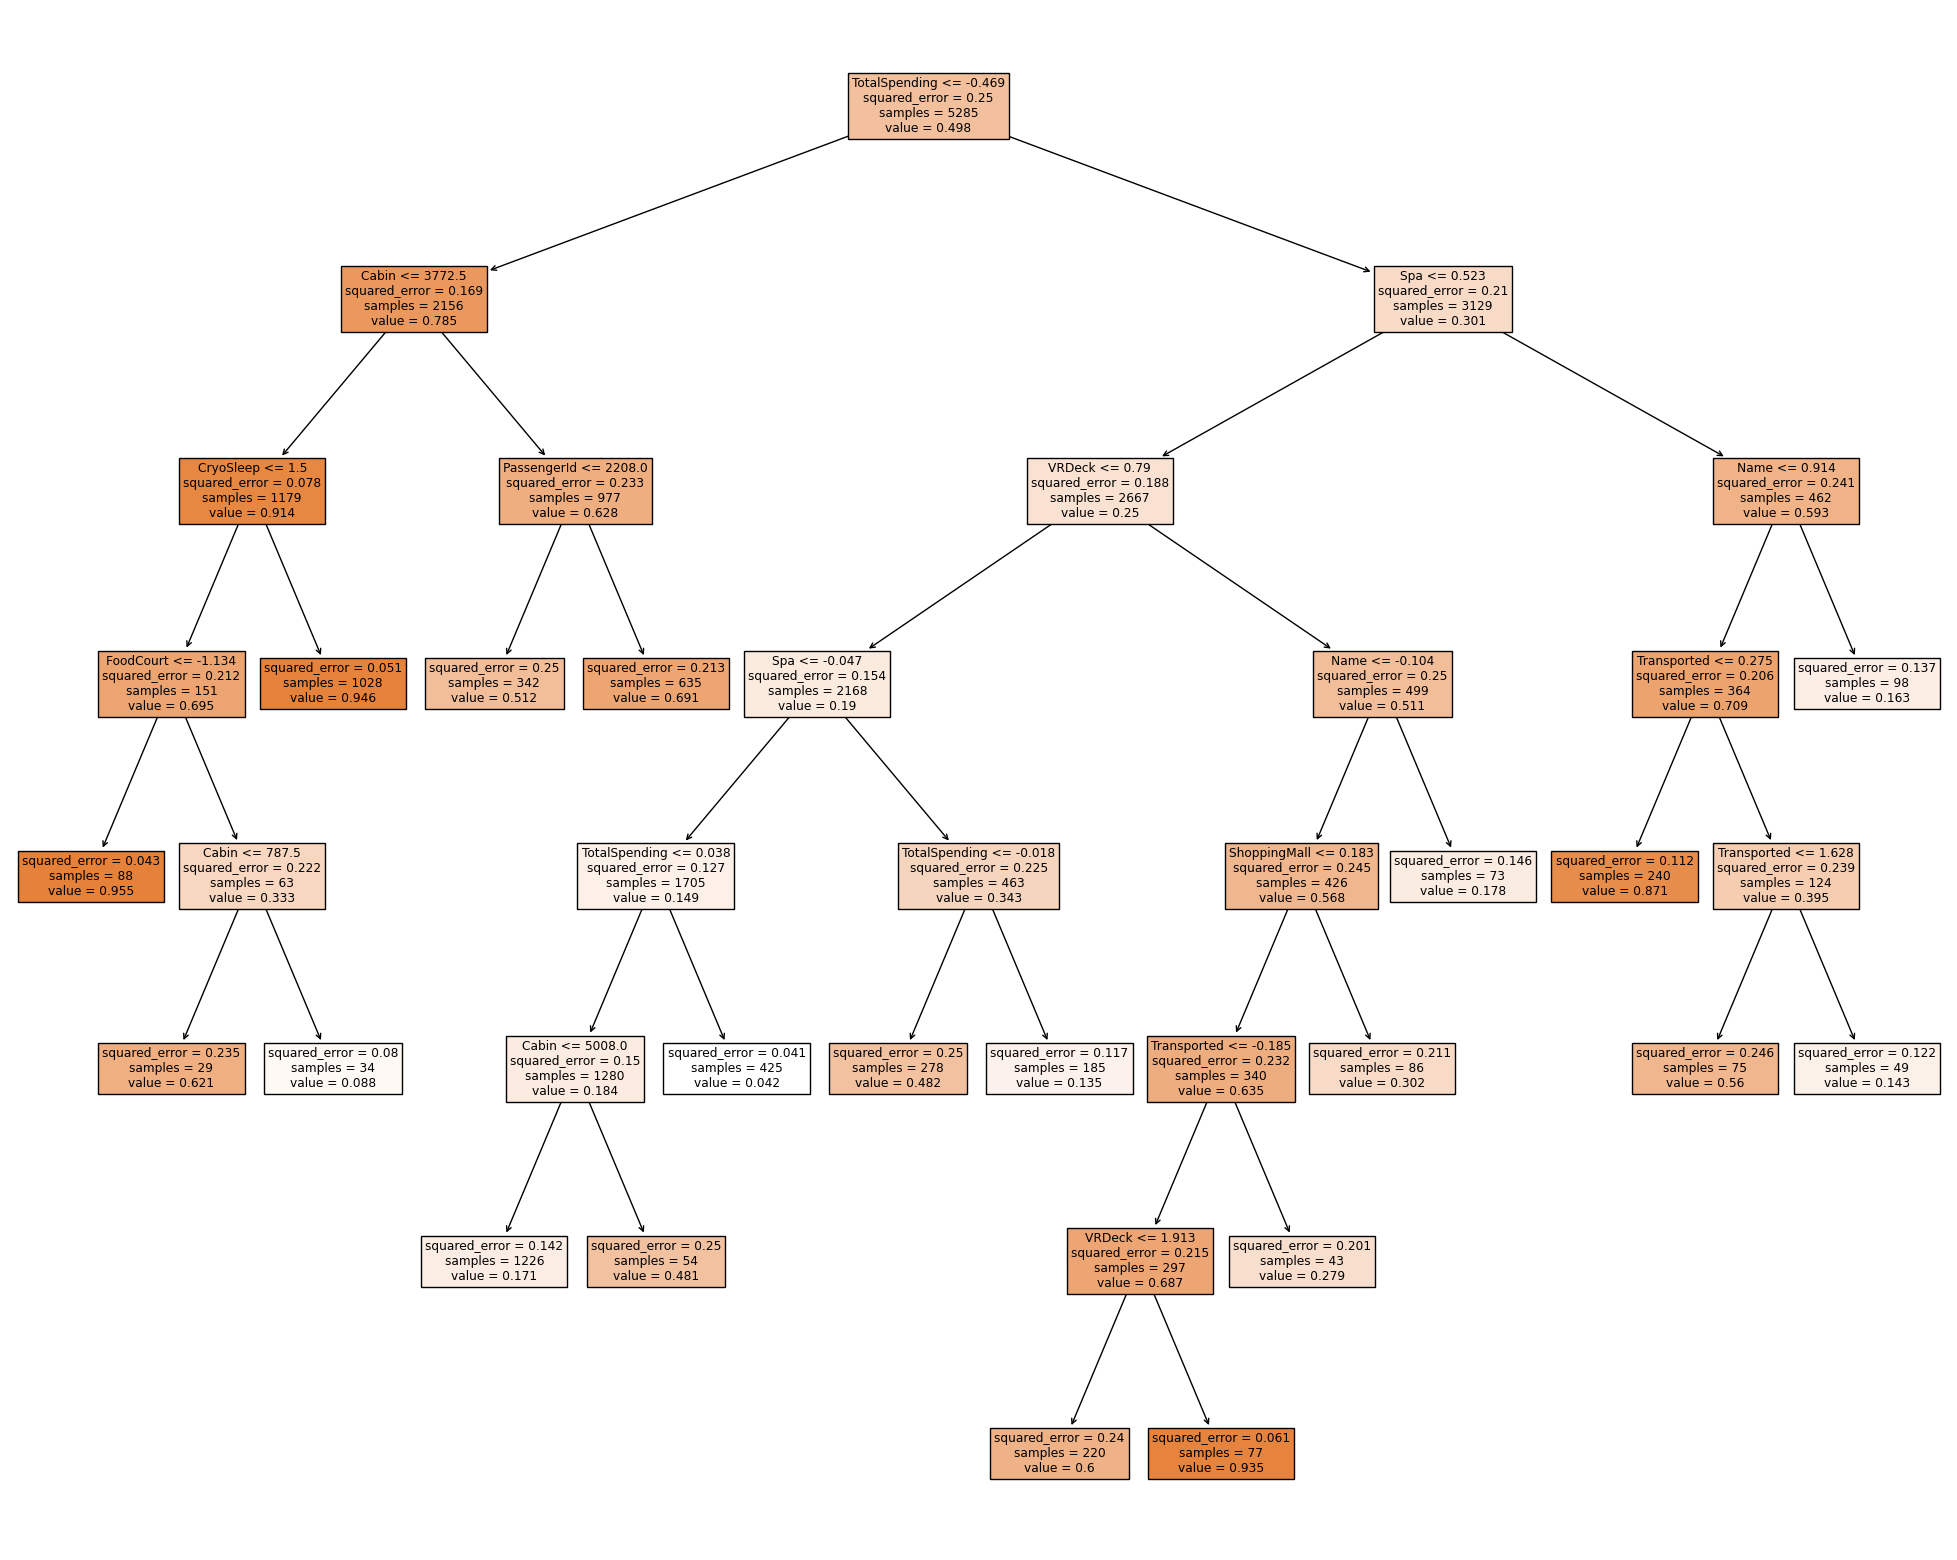

In [98]:



splits = RandomSplitter(seed = 1)(range_of(traindf))
dep_var = 'Transported'
procs = [Categorify,FillMissing,Normalize]
cont,cat = cont_cat_split(traindf, 1, dep_var=dep_var)
to = TabularPandas(traindf, procs, cat, cont, y_names=dep_var,splits = splits)

xs,y = to.train.xs,to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

m = DecisionTreeRegressor(max_leaf_nodes=20)
m.fit(xs, y)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(m,
                   feature_names= traindf.columns,
                   filled=True)

print('decision tree prediction',((m.predict(valid_xs) > 0.5) == valid_y).sum() / len(valid_y))



In [110]:




m = RandomForestClassifier(n_estimators= 100, max_leaf_nodes= 50)
m.fit(xs, y)
preds = m.predict(valid_xs)
print("mae",mean_absolute_error(valid_y, preds))
print('preds', (preds == valid_y).sum() /len(valid_y))





mae 0.2043906131718395
preds 0.7956093868281605


In [111]:

traindf.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'TotalSpending', 'asleepymoney'],
      dtype='object')

In [113]:
(traindf.VIP == True).sum()

162

In [8]:
traindf[(traindf.CryoSleep == False) & (traindf.RoomService > 0)].Transported.value_counts()

Transported
False    1679
True      609
Name: count, dtype: int64

In [119]:
traindf[traindf.VIP == True].Transported.value_counts()

Transported
False    102
True      60
Name: count, dtype: int64

In [130]:
traindf.Destination.unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e'], dtype=object)

In [133]:
traindf[(traindf.CryoSleep ==False) & (traindf.VIP == True) & (traindf.Destination ==  '55 Cancri e')].Transported.value_counts()

Transported
False    31
True     13
Name: count, dtype: int64

In [120]:
traindf[(traindf.TotalSpending == 0) & (traindf.VIP == True)].Transported.value_counts()

Transported
True     21
False     2
Name: count, dtype: int64

In [106]:


def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)
print(fi[:30])


             cols       imp
14  TotalSpending  0.191944
7    asleepymoney  0.125486
12            Spa  0.099702
2       CryoSleep  0.098563
10      FoodCourt  0.080759
13         VRDeck  0.077965
9     RoomService  0.075233
11   ShoppingMall  0.066999
3           Cabin  0.061498
1      HomePlanet  0.039656
8             Age  0.030289
0     PassengerId  0.023418
6            Name  0.017912
4     Destination  0.010041
5             VIP  0.000534
